In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

## Do Deeper Networks Solve the Problem?

If $\frac{|\lambda_{2}|}{|\lambda_{1}|}\approx{}1$, then the summand in $d_{Katz}$, $(\alpha{}A)^{k}\vec{1}$,  requires $k>>0$ before converging to the dominant eigenvector, $v_{1}$,

$$d_{Katz} = \sum_{k=0}^{n} (\alpha{}A)^{k}\vec{1} + \vec{v_{1}}\sum_{k=n+1}^{\infty}\alpha{}^{k}$$

at which point the second term can be computed without further powers of $A$. We can view the above equation as a series of graph convolutions followed by an MLP regression head. In this sense, it is likely that deeper GCNs are required to learn the Katz Centrality of low-density, high eigenvalue-ratio SBMs. 

### Model and Dataset Code

SBMs are the same as Section 2.7.2, with $p\in{}[\frac{1}{50n},\frac{1}{n}]$. We still consider only the undirected, unweighted case.

In [40]:
torch.manual_seed(0)

num_graphs = 3000
d = []
for _ in range(num_graphs):
    # Set Cluster sizes and edge probabilities
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T),dim=1)
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    d[idx] = G
    
train,test = d[:2000],d[2000::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [41]:
# Compute the Mean Average Distance of inputs
def batched_MAD(X,edge_index,edge_weights):
    X = X/torch.norm(X,dim=1)[:,None]
    cosine = 1 - torch.sum(X[edge_index[0]] * X[edge_index[1]],dim=1).abs()
    return 1/edge_weights.sum() * (edge_weights * cosine).sum()

# Compute the Global Feature Similarity
def batched_GFS(X,edge_index,edge_weights,batch):
    X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
    
    GFS = 0
    for idx,batch_idx in enumerate(batch.unique()):
        cosine = torch.clip(1 - torch.matmul(X[batch==batch_idx].T,X[batch==batch_idx]).abs(),0,1)
        GFS += cosine.sum()/(cosine.shape[0]*(cosine.shape[0]-1))
    
    return GFS/(idx+1)
# Compute normalized (absolute) rayleigh quotient
def rayleigh_quotient(X,edge_index,edge_weights,batch,eig_max,eig_min):
    num = torch_scatter.scatter_sum(X * torch_scatter.scatter_sum(edge_weights[:,None] * 
                                        X[edge_index[1]], edge_index[0],dim=0),
                                        batch, dim=0)
    denom = torch_scatter.scatter_sum(X**2,batch,dim=0)
    R = num/(denom)
    return torch.mean((eig_max[:,None] - R.abs())/(eig_max - eig_min)[:,None])

In [42]:
graph_results = []
metrics = []
for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    graph = GraphConv(1,32,1,k).cuda()
    
    graph_results.append(train_loop(graph,train_loader,test_loader,150,lr=1e-2))
    torch.save(graph.state_dict(),'base_{}'.format(k))

    # Iterate through network layers and compute the MAD/Agg at each
    MAD,GFS,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
    for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        row,col = data.edge_index[0].cuda(),data.edge_index[1].cuda()
        batch = data.batch.cuda()

        graph.eval()
        X = graph.start(X)
        
        for jdx,m in enumerate(graph.intermediate):
            X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
            X = torch.nn.LeakyReLU()(graph.bn[jdx](X))
            MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
            GFS[jdx] += batched_GFS(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
            Ray[jdx] += rayleigh_quotient(X,data.edge_index.cuda(),data.edge_weight.cuda(),
                                    batch,data.eig_max.cuda(),data.eig_min.cuda()).item()
    metrics.append([MAD/(idx+1),GFS/(idx+1),Ray/(idx+1)])
    torch.cuda.empty_cache()

torch.save(metrics,'base_metrics')
torch.save(graph_results,'base_results')

### Results

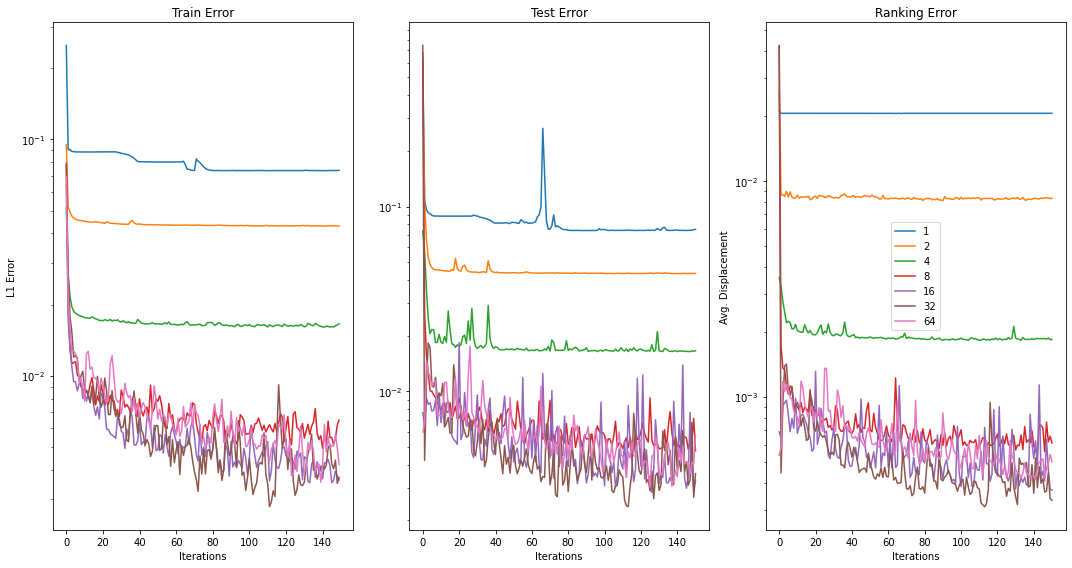

In [5]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement for $l_{max}=1,2,4,...,64$. We also plot below the best values on the train and test loss (over the final 50 epochs) versus number of parameters. 

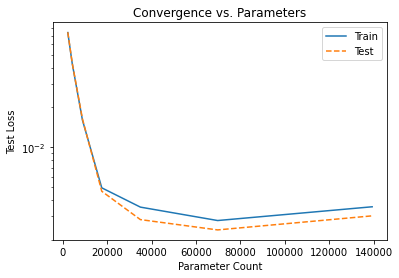

In [18]:
params = [2200,4200,8801,17505,34913,69729,139361]
plt.semilogy(params,[np.min(graph_results[i][0][-50::]) for i in range(7)],label='Train')
plt.semilogy(params,[np.min(graph_results[i][1][-50::]) for i in range(7)],linestyle='--',label='Test')
plt.legend();
plt.xlabel('Parameter Count')
plt.ylabel('Test Loss');
plt.title('Convergence vs. Parameters');

Increasing GCN depth leads to some improvement; however, the loss stagnates past $l_{max}=8$ relative to parameter count, and it decays for both the train and test set from $l_{max}=32$ to $l_{max}=64$. Moreover, we are yet to even break the $10^{-3}$ mark, so performance is not on par with the high-density dataset or $d_{degree}$ case. We suspect GraphConv is either a) having difficuilty backpropagating due to the greater model depth or b) running into convergence issues with the increased number of convolutions.

### Some Analysis

#### Adding Residual Connections

To assess whether network depth is having deleterious effects on backpropagation, we train an $l_{max}=64$ GraphConv model with 1-hop residual connections following each non-linearity. If there is truly an issue with backprop, then we should expect to see improvement over the non-residual model.

In [21]:
class ResidualGraphConv(torch.nn.Module):
    # in_channels and out_channels are self-explanatory. int_channels is the number of 
    # features in the intermediate layers. Depth controls the number of aggregations.
    def __init__(self,in_channels,int_channels,out_channels,depth):
        super(ResidualGraphConv,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.bn = torch.nn.ModuleList([torch_geometric.nn.BatchNorm(int_channels) for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        
    def forward(self,X,edge_index,edge_weight,batch):
        # Project to int_channels
        X = self.start(X)
        
        # Run through GraphConv layers
        for idx,m in enumerate(self.intermediate):
            nX = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = X + torch.nn.LeakyReLU()(self.bn[idx](nX))
            
        # Project to out_channels
        return self.finish(X)

In [22]:
residual_results = []

torch.manual_seed(0)
graph = ResidualGraphConv(1,32,1,64).cuda()

residual_results.append(train_loop(graph,train_loader,test_loader,150,lr=1e-1))
torch.save(residual_results,'residual_results{}'.format(64))
torch.cuda.empty_cache()

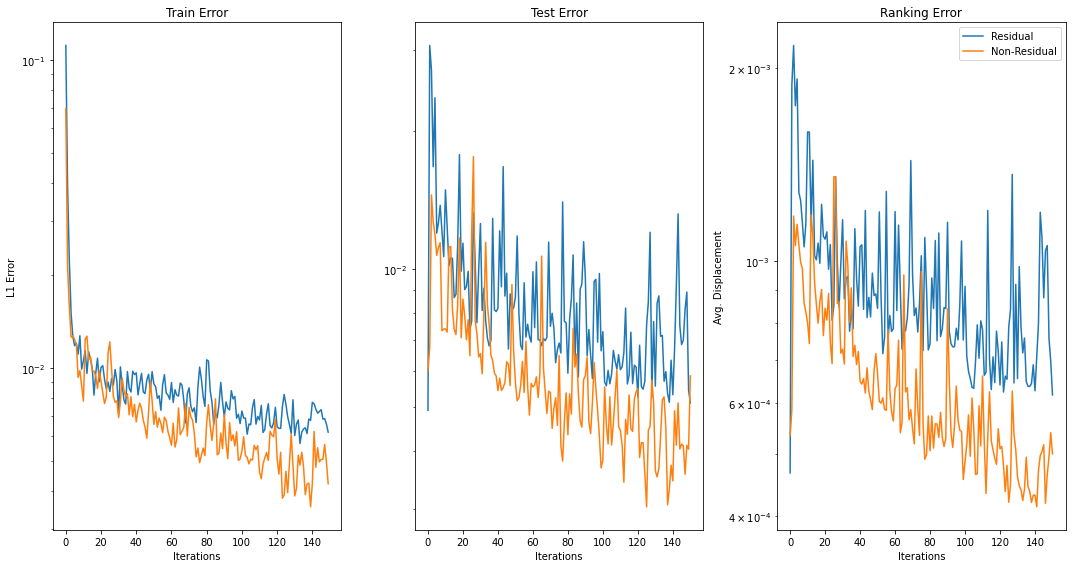

In [23]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(residual_results[0][0])
plt.semilogy(graph_results[-1][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(residual_results[0][1])
plt.semilogy(graph_results[-1][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(residual_results[0][2],label='Residual')
plt.semilogy(graph_results[-1][2],label='Non-Residual')

plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement at $l_{max}=64$ for both the residual and non-residual models. Oddly enough, adding residual connections slightly hampers both the traning and test loss. This contradicts the hypothesis that our deeper models are underperforming due to backpropgation issues. 

#### Evaluating the Number of Convolutions

Wu et. al. (2019) introduced the Simplified Graph Convolution (SGC) [17]

$$X^{out} = \Theta{}(A^{l_{max}}X^{in})$$

In practice, they found that removing the non-linearities at each GCN layer did not impact classification accuracy whilst greatly reducing training time and maintaining a constant parameter count. We follow the example of [16] (and others) and use SGC to estimate the impact of a greater number of convolutions independent of parameter count. We train for all $l_{max}=1,2,4,...,64$. $\Theta$ is a four-layer MLP with BatchNorm and LeakyReLU nonlinearity. $A^{l_{max}}X^{in}$ is computed through succesive matrix-matrix products; for the sake of stability, we normalize the columns at each iteration.

In [24]:
class SGC(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,k=2):
        super(SGC,self).__init__()

        self.finish = torch.nn.Sequential(*[torch.nn.Linear(1,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch_geometric.nn.BatchNorm(int_channels),torch.nn.LeakyReLU(),
                                            torch.nn.Linear(int_channels,int_channels),torch_geometric.nn.BatchNorm(int_channels),torch.nn.LeakyReLU(),
                                            torch.nn.Linear(int_channels,out_channels)])
        self.k = k

    def forward(self,X,edge_index,edge_weight,batch):
        for _ in range(self.k):
              X = torch_scatter.scatter_sum(edge_weight[:,None] * X[edge_index[1]],edge_index[0],dim=0)
              X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
        return self.finish(X)

In [25]:
sgc_results = []
metrics = []

for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    model = SGC(1,32,1,k).cuda()

    sgc_results.append(train_loop(model,train_loader,test_loader,50,lr=1e-1))

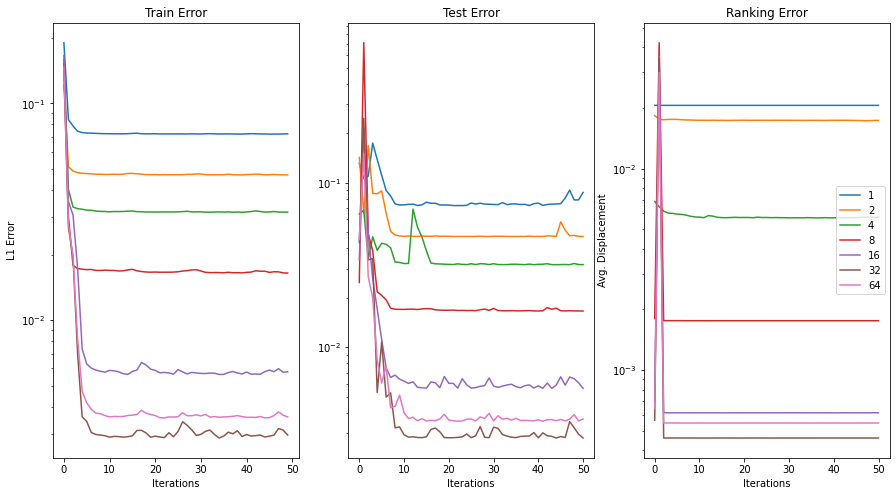

In [26]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(sgc_results[idx][0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(sgc_results[idx][1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(sgc_results[idx][2],label=k)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.show()

Convergence is nigh-instantaneous (owing to the small parameter count), so we only train for a third of the epochs. As with GraphConv, the performance of SGC decays from $l_{max}=32$ to $l_{max}=64$ (the losses are somewhat smaller, although that may just be because GraphConv requires further training to fully converge). This suggests it is the act of adding additional convolutions, not necesarily more parameters, that is causing our deepest model to underperform. However, it still does not explain why all of our results remain worse than those for the high-density dataset.

### GCN Smoothing

GCNs suffer from a peculiar phenomena known as *oversmoothing*. In essence, performance tends to degrade as you add more layers, as the features of each node converge to fixed values. Current theoretical analysis of oversmoothing has been focused on the GCNConv operator of Kipf and Welling [15].

$$X^{l+1} = (\hat{D}^{\frac{-1}{2}}\hat{A}\hat{D}^{\frac{-1}{2}})X^{l}W$$
$$ \hat{A} = I + A \; \; \; \; \hat{D} = \hat{A}\vec{1}$$

This is a psuedo-spectral convolution, in it that aggregates using a form of the symmetric normalized graph Lapalcian $L_{sym} = I - D^{\frac{-1}{2}}AD^{\frac{-1}{2}}$. By definition, $L_{sym}$ possesses eigenvalues $0\leq{}\lambda_{i}\leq{}2$. We are  guaranteed an eigenvector $v_{i}=D^{\frac{1}{2}}\vec{1}$ for $i$ such that $\lambda_{i}=0$, and dropping $I$ shifts the eigenvalue spectra, making $v_{i}$ dominant. The asymptoptic behavior of the GCNConv aggregation step is to therefore diffuse material until it is distributed according to the square root of the augmented node degree $\hat{D}$. Since most real-life networks possess approximately power-law degree distributions, the majority of nodes will eventually become indistinguishable; this is the root of the oversmoothing problem in GCNConv. However, the literature demonstrates that spatial convolution algorithms, which do not explicitly incorporate $L_{sym}$, are no less vulnerable [14,16] to oversmoothing. As an example, we train our GraphConv model without Batch Normalization on the Citeseer benchmark and report on the smoothness of its intermediate representations. We choose to measure this by the sparsified Mean Average Distance (MAD) [14],

$$MAD(X^{l},E,V) = \frac{1}{|V|}\sum_{i\in{V}}(\frac{1}{\sum_{i,j\in{}E}w_{ij}}\sum_{i,j\in{}E}w_{ij}(1 - \frac{|(x_{j}^{l})^{T}x^{l}_{i}|}{||x^{l}_{i}||_{2}||x^{l}_{j}||_{2}}))$$

Global Feature Similarity (or GFS),

$$GFS(X^{l},E,V) = \frac{2}{m(m-1)}\sum_{i=0}^{m}\sum_{j=i+1}^{m}(1 - \frac{|(X_{:,i}^{l})^{T}X_{:,j}^{l}|}{||X^{l}_{:,i}||_{2}||X^{l}_{:,j}||_{2}})$$

and the absolute Rayleigh Quotient,

$$R(X^{l},A,V) = \frac{1}{|V|}\sum_{i\in{}V}(\frac{1}{\lambda_{max}-\lambda_{min}}(\lambda_{max} - |\frac{\vec{x}^{l}_{i}A\vec{x}^{l}_{i}}{\vec{x}^{l}_{i}\cdot{}\vec{x}^{l}_{i}}|))$$

with MinMax normalization. $\lambda_{max}$ and $\lambda_{min}$ are the eigenvalues of $A$ with, respectively, the largest and smallest absolute values. MAD quantifies the similarity of adjacent nodes, whereas NAD measures how close the columns $X_{:,i}^{l}$ are to one another. Both employ the cosine distance for scale invariance. The normalized Rayleigh Quotient reflects how close each column is to the dominant eigenvector $v_{1}$, with $R(X^{l})=0$ indicating they are equivalent. 

In [4]:
def citeseer_train_loop(model,data,epochs,lr=1e-3):
    train_loss = []
    test_loss = []

    try: opt = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-1)
    except: pass;
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    model.eval()
    with torch.no_grad():
        X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        preds = model(X,edge_index,edge_weight,batch)
        test_loss.append(torch.mean((preds[data.test_mask].argmax(dim=1)==Y[data.test_mask]).float()))

    for epoch in range(epochs):
        model.train()
        X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        preds = model(X,edge_index,edge_weight,batch)

        loss = torch.nn.CrossEntropyLoss()(preds[data.train_mask],Y[data.train_mask])
        train_loss.append(torch.mean((preds[data.train_mask].argmax(dim=1)==Y[data.train_mask]).float()))

        loss.backward()
        opt.step()
        opt.zero_grad()

            
        model.eval()
        with torch.no_grad():
            X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
            batch = data.batch.cuda()

            preds = model(X,edge_index,edge_weight,batch)
            test_loss.append(torch.mean((preds[data.test_mask].argmax(dim=1)==Y[data.test_mask]).float()))

    return train_loss,test_loss

In [5]:
citeseer = torch_geometric.datasets.Planetoid('.','Citeseer',split='full')[0]
citeseer.edge_index = torch_geometric.utils.to_undirected(citeseer.edge_index)

citeseer.edge_weight = torch.ones((citeseer.edge_index.shape[1]))
citeseer.batch = torch.zeros((citeseer.x.shape[0])).long()
val = torch.eig(torch_sparse.SparseTensor(row=citeseer.edge_index[0],col=citeseer.edge_index[1],
                                          value=citeseer.edge_weight).to_dense())[0]
val = torch.norm(val,dim=1)
citeseer.eig_min = val.min() * torch.ones((1))
citeseer.eig_max = val.max() * torch.ones((1))

In [22]:
citeseer_results = []
citeseer_metrics = []

for k in [1,2,4,6,8,10,12,14,16]:
    torch.manual_seed(0)
    model = GraphConv(citeseer.x.shape[-1],16,len(citeseer.y.unique()),k,norm=False).cuda()

    citeseer_results.append(citeseer_train_loop(model,citeseer,200,lr=1e-2))
    
    # Iterate through network layers and compute the MAD/Agg at each
    MAD,GFS,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
    X = citeseer.x.cuda()
    row,col = citeseer.edge_index[0].cuda(),citeseer.edge_index[1].cuda()
    batch = citeseer.batch.cuda()

    model.eval()
    X = model.start(X)
        
    for jdx,m in enumerate(model.intermediate):
        X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
        X = torch.nn.LeakyReLU()(X)
        MAD[jdx] += batched_MAD(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda()).mean().item()
        GFS[jdx] += batched_GFS(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda(),batch).item()
        Ray[jdx] += rayleigh_quotient(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda(),
                                batch,citeseer.eig_max.cuda(),citeseer.eig_min.cuda()).item()
            
    citeseer_metrics.append([MAD,GFS,Ray])
    torch.cuda.empty_cache()

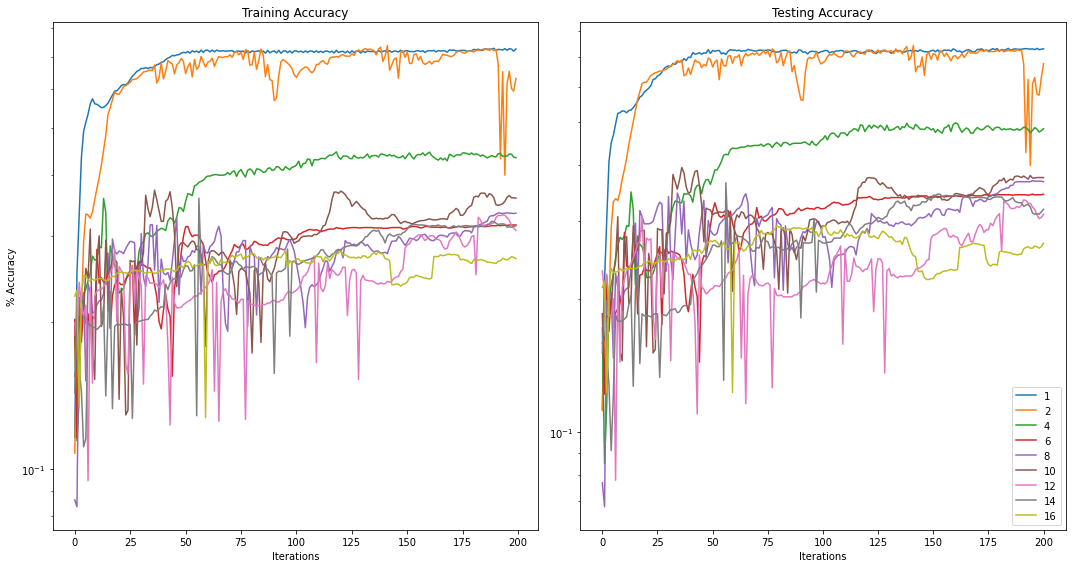

In [23]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
for i in range(9):
  plt.semilogy(citeseer_results[i][0])

plt.title('Training Accuracy')
plt.ylabel('% Accuracy')
plt.xlabel('Iterations')

plt.subplot(1,2,2)
for idx,label in enumerate([1,2,4,6,8,10,12,14,16]):
  plt.semilogy(citeseer_results[idx][1],label=label)

plt.legend();
plt.title('Testing Accuracy')
plt.xlabel('Iterations')

plt.tight_layout();

Mediocre accuracy aside (it can be boosted with some architectural modifications), increasing the depth of GraphConv negatively impacts the performance on CiteSeer. Below we plot the minimum MAD, GFS, and normalized Rayleigh across all layers versues $l_{max}$. We justify looking at the minimum in that, once oversmoothing occurs in any given layer, the network will be unable to recover the initial set of node features. It may happen upon less smooth representations in subsequent layers, sure, but they are going to be independent of the input. 

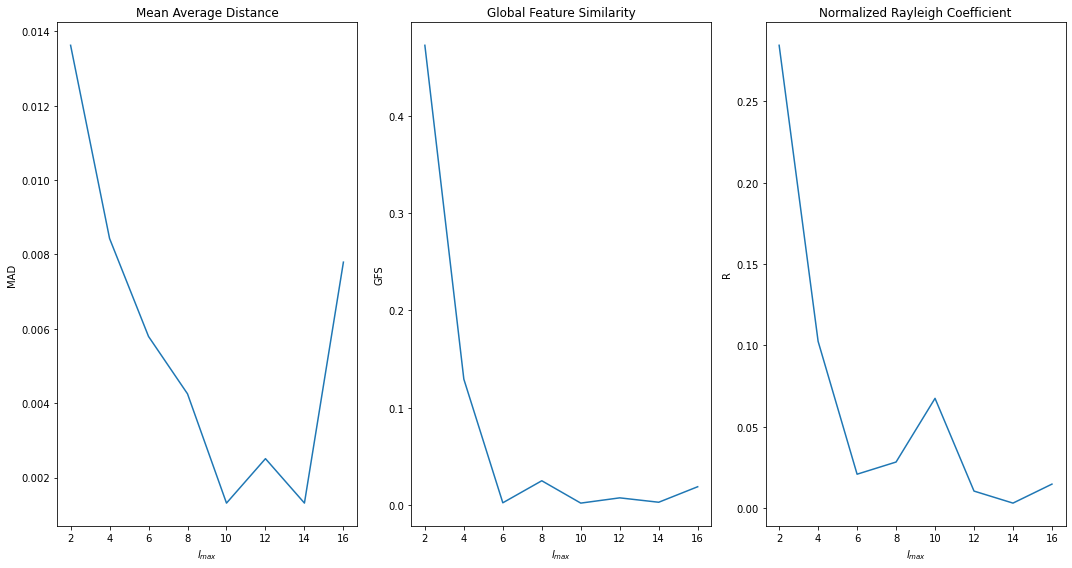

In [32]:
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  mad = []
  for idx,l in enumerate([2,4,6,8,10,12,14,16]):
    mad.append(citeseer_metrics[idx+1][0].min().item())
  plt.plot([2,4,6,8,10,12,14,16],mad)
  plt.xlabel('$l_{max}$')
  plt.ylabel('MAD')
  plt.title('Mean Average Distance')

  plt.subplot(1,3,2)
  gfs = []
  for idx,l in enumerate([2,4,6,8,10,12,14,16]):
    gfs.append(citeseer_metrics[idx+1][1].min().item())
  plt.plot([2,4,6,8,10,12,14,16],gfs)
  plt.xlabel('$l_{max}$')
  plt.ylabel('GFS')
  plt.title('Global Feature Similarity')

  plt.subplot(1,3,3)
  ray = []
  for idx,l in enumerate([2,4,6,8,10,12,14,16]):
    ray.append(citeseer_metrics[idx+1][2].min().item())
  plt.plot([2,4,6,8,10,12,14,16],ray)
  plt.xlabel('$l_{max}$')
  plt.ylabel('R')
  plt.title('Normalized Rayleigh Coefficient')

  plt.tight_layout()
  plt.show()

The minimum MAD is not only quite small for all models, but it also takes comparatively long to degrade and jumps for $l_{max}=16$. Meanwhile, both the GFS and $R$ start high and quickly decay towards zero; the latter even reflects the (relative) success of the $l_{max}=8$ and $l_{max}=16$ models in the form of small spike. Correlation coefficients between our metrics and the final test accuracy are as follows:

In [36]:
final_acc = [citeseer_results[idx][1][-1].item() for idx in range(1,9)]

print("MAD: {}".format(np.corrcoef(mad,final_acc)[0,1]))
print("GFS: {}".format(np.corrcoef(gfs,final_acc)[0,1]))
print("Rayleigh: {}".format(np.corrcoef(ray,final_acc)[0,1]))

MAD: 0.7558105798316285
GFS: 0.9474605441849474
Rayleigh: 0.9734328705739541


GFS and $R$ are broadly more correlated with model performance than the MAD. This squares with the notion that oversmoothing is the result of the asymmptotic behavior of the GCN aggregation step (i.e: converging to our dominant eigenvector), which GFS and Rayleigh measure more directly. 

Now, oversmoothing may be an issue when dealing with node and graph classification, but it is quite helpful if we are interested purely in network structure. Oversmoothing "washes away" any feature biases, leaving only information about the underlying graph topology. In our case, we actually want our models to converge to something close to $v_{1}$, seeing as to the previously stated connection between $d_{Katz}$ and $d_{eig}$. 

To demonstrate, we retrain an $l_{max}=4$ model on the high-density dataset and compare its minimum MAD, GFS, and Rayleigh Quotient against those of our low-density GCNs.

In [38]:
torch.manual_seed(0)

num_graphs = 3000
d = []
for _ in range(num_graphs):
    # Set Cluster sizes and edge probabilities
    n = torch.randint(50,100,(5,))
    p = 1/(n) + (9/n) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T),dim=1)
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    d[idx] = G
    
train,test = d[:2000],d[2000::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [39]:
torch.manual_seed(0)

dense_model = GraphConv(1,32,1,4).cuda()

dense_results = train_loop(dense_model,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()
MAD,GFS,Ray = torch.zeros(4),torch.zeros(4),torch.zeros(4)
    
for idx,data in enumerate(test_loader):
    X = data.x.cuda()
    row,col = data.edge_index[0].cuda(),data.edge_index[1].cuda()
    batch = data.batch.cuda()

    dense_model.eval()
    X = dense_model.start(X)

    for jdx,m in enumerate(dense_model.intermediate):
        X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
        X = torch.nn.LeakyReLU()(dense_model.bn[jdx](X))
        MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
        GFS[jdx] += batched_GFS(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
        Ray[jdx] += rayleigh_quotient(X,data.edge_index.cuda(),data.edge_weight.cuda(),
                                batch,data.eig_max.cuda(),data.eig_min.cuda()).item()
        
    dense_metrics = [MAD/(idx+1),GFS/(idx+1),Ray/(idx+1)]

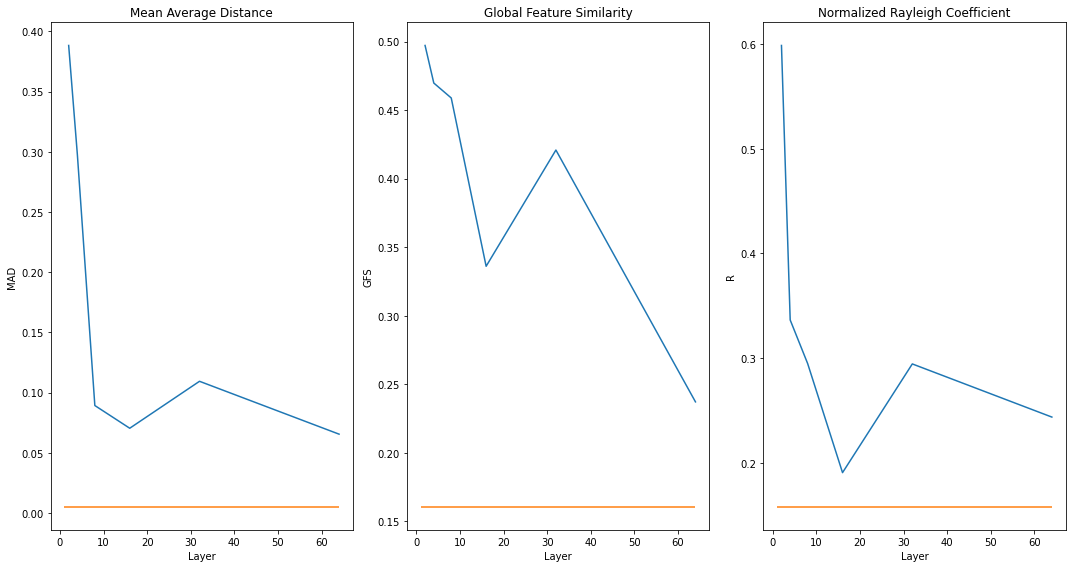

In [50]:
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  m = []
  for idx,l in enumerate([2,4,8,16,32,64]):
    m.append(metrics[idx+1][0].min())
  plt.plot([2,4,8,16,32,64],m)
  plt.hlines(dense_metrics[0].min(),1,64,colors='tab:orange')
  plt.xlabel('Layer')
  plt.ylabel('MAD')
  plt.title('Mean Average Distance')

  plt.subplot(1,3,2)
  m = []
  for idx,l in enumerate([2,4,8,16,32,64]):
    m.append(metrics[idx+1][1].min())
  plt.plot([2,4,8,16,32,64],m)
  plt.hlines(dense_metrics[1].min(),1,64,colors='tab:orange')

  plt.xlabel('Layer')
  plt.ylabel('GFS')
  plt.title('Global Feature Similarity')

  plt.subplot(1,3,3)
  m = []
  for idx,l in enumerate([2,4,8,16,32,64]):
    m.append(metrics[idx+1][2].min())
  plt.plot([2,4,8,16,32,64],m)
  plt.hlines(dense_metrics[2].min(),1,64,colors='tab:orange')
  plt.xlabel('Layer')
  plt.ylabel('R')
  plt.title('Normalized Rayleigh Coefficient')

  plt.tight_layout()
  plt.show()

For the dense dataset, our model converges rapidly to $v_{1}$ with only $l_{max}=4$, as indicated by the small $R$ and GFS. None of the models trained on the low-density data can match this, much less ones of similar depth. And, aside from GFS, their metrics stop meaningfully decreasing past $l_{max}=16$. 

Let us look at how MAD, GFS and $R$ vary layer-by-layer, starting with the high-density model:

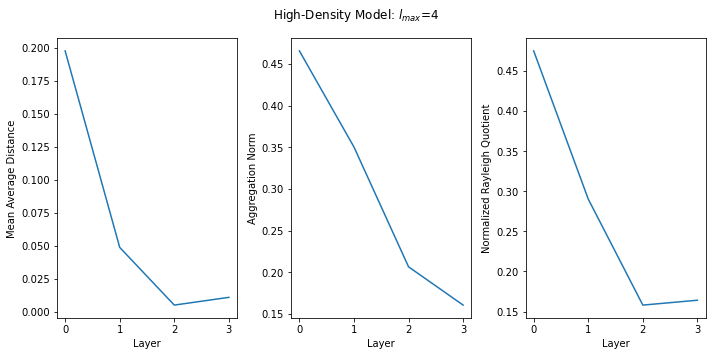

In [57]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.plot(dense_metrics[0],label='MAD')
plt.xlabel('Layer')
plt.ylabel('Mean Average Distance')

plt.subplot(1,3,2)
plt.plot(dense_metrics[1])
plt.xlabel('Layer')
plt.ylabel('Aggregation Norm')

plt.subplot(1,3,3)
plt.plot(dense_metrics[2])
plt.xlabel('Layer')
plt.ylabel('Normalized Rayleigh Quotient')

plt.suptitle("High-Density Model: $l_{max}$=4")
plt.tight_layout()
plt.show()


There is a consistent decrease in all three metrics as we go through successive GCN layers. MAD and $R$ increase following the third aggregation, but GFS still continues to decline, albeit at a slower rate. The minimum values are located at or near the final layer. This is quite a different picture to the low-density model:

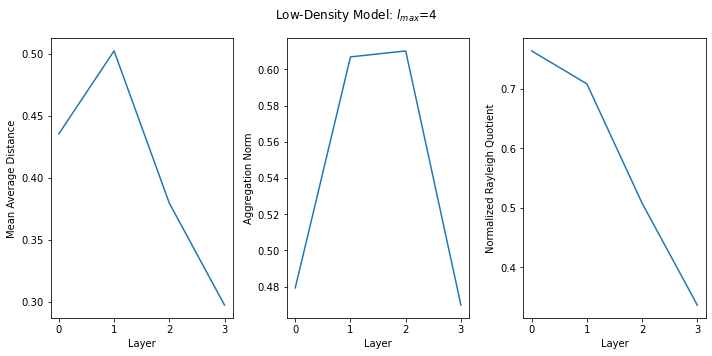

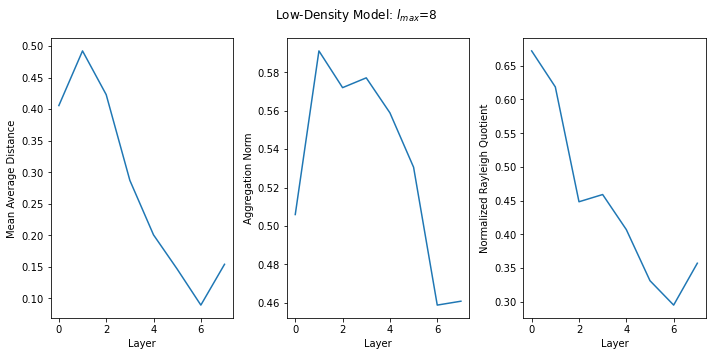

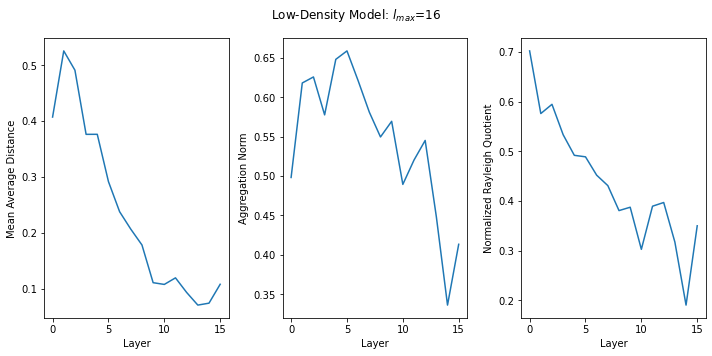

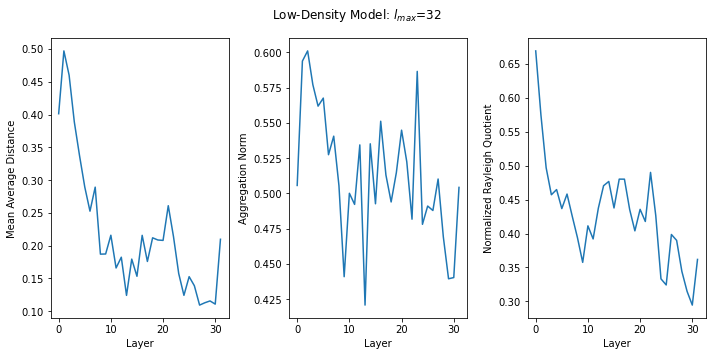

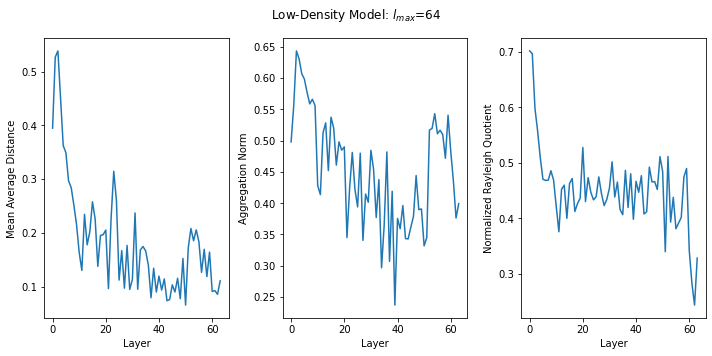

In [58]:
for idx,l in enumerate([4,8,16,32,64]):
  plt.figure(figsize=(10,5))

  plt.subplot(1,3,1)
  plt.plot(metrics[idx+2][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx+2][1])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx+2][2])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh Quotient')
    
  plt.suptitle("Low-Density Model: $l_{max}$="+str(l))
  plt.tight_layout()
  plt.show()


Our metrics for the low-density models exhibit an initial decline followed by growing oscillations as $l_{max}$ increases. Both GFS and MAD tend to worsen in the first few layers before beginning to decay. Like with the high-density case, the minimum values tend to be towards the end of the model. 

Each GCN is clearly attempting to drive $R$ down, yet is unable to achieve the same success as the high-density model. Even the deeper networks, which should be able to overcome the greater eigenvalue ratio, only do so much. In the next section, we investigate the role normalization may be playing in this and introduce a method to close the topology performance gap.